# Data cleaning
This notebook takes as input a raw .tsv file from the motion tracking software, and converts it to a cleaned file to be used for later data analysis.

The notebook is set up as follows:
1. Importing packages and reading data
2. Renaming columns, removing unwanted data, separating locusts and arena markers
3. Finding radius and center of arena
4. Shifting and rescaling position coordinates of locusts


## 1. Importing packages and reading data

In [1]:
import pandas as pd  #The main package we will be using for data analysis. Used to read CSVs/TSVs, work with dataframe objects, and many other things.
import matplotlib.pyplot as plt  #The standard plotting package, used for making nice pretty pictures.
#import os  #We might need this to deal with filenames and paths.
#import random  #Used to generate random numbers
import numpy as np  #We might need this, it's a pretty standard package. 
#import seaborn as sns
from scipy import stats
import skg

In [2]:
# Put the location of the data folder on your computer

data_location = 'D:/Data/Hangar-Locust/'
subfolder = '2K-locust_14112022/'

In [3]:
# Reads the .tsv file as a pandas DataFrame. We skip the first 11 rows because that is the metadata at the start, and we choose the Time column to be our index column. 
df = pd.read_csv(data_location + subfolder + '200_locust_11142022_0002.tsv', sep='\t', skiprows=11, index_col='Time')

In [4]:
# We will create a new dataframe ndf to avoid messing with the old one
ndf = df.copy()
ndf

,Frame,X,Y,Z,X.1,Y.1,Z.1,X.2,Y.2,Z.2,...,X.1297,Y.1297,Z.1297,X.1298,Y.1298,Z.1298,X.1299,Y.1299,Z.1299,Unnamed: 3902
Time,,,,,,,,,,,,,,,,,,,,,
0.00,1,1537.634,2943.620,371.787,574.688,10.452,50.055,200.860,2469.208,358.624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.01,2,1537.635,2943.619,371.791,574.685,10.449,50.040,200.857,2469.210,358.608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.02,3,1537.634,2943.615,371.800,574.678,10.445,50.031,200.856,2469.212,358.605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.03,4,1537.637,2943.622,371.795,574.683,10.445,50.013,200.860,2469.209,358.610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.04,5,1537.691,2943.882,370.912,574.651,10.268,49.610,200.787,2469.282,358.030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969.67,96968,1537.651,2943.890,370.864,574.756,10.420,49.738,200.493,2469.349,357.976,...,NaN,NaN,NaN,NaN,NaN,NaN,1621.367,2541.643,84.370,NaN
969.68,96969,1537.652,2943.888,370.852,574.755,10.424,49.743,200.487,2469.346,357.983,...,NaN,NaN,NaN,NaN,NaN,NaN,1621.398,2541.607,84.384,NaN
969.69,96970,1537.650,2943.888,370.850,574.757,10.418,49.743,200.484,2469.352,357.986,...,NaN,NaN,NaN,NaN,NaN,NaN,1621.345,2541.636,84.367,NaN


## 2. Renaming columns, removing unwanted data, separating locusts and arena markers

In [5]:
# The first three x,y,z columns should be renamed to x0,y0,z0.
ndf = ndf.rename(columns={" X": " X.0", " Y": " Y.0", " Z": " Z.0"})

# We also want to get rid of any annoying spaces in the column names
ndf = ndf.rename(str.strip, axis='columns')

In [6]:
# We can access the columns of the dataframe by using df.columns
ndf.columns

Index(['Frame', 'X.0', 'Y.0', 'Z.0', 'X.1', 'Y.1', 'Z.1', 'X.2', 'Y.2', 'Z.2',
       ...
       'X.1297', 'Y.1297', 'Z.1297', 'X.1298', 'Y.1298', 'Z.1298', 'X.1299',
       'Y.1299', 'Z.1299', 'Unnamed: 3902'],
      dtype='object', length=3902)

In [7]:
# The command df.info() gives us some useful information about the dataframe. 
print(ndf.info())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 96972 entries, 0.0 to 969.71
Columns: 3902 entries, Frame to Unnamed: 3902
dtypes: float64(3901), int64(1)
memory usage: 2.8 GB
None


In [8]:
# We notice that a lot of the entries are NaN. We would like to get rid of the columns where > 90% of the data is NaN. 


# We want to delete any columns that have more than 90% NaN. 
# First, find the columns we want to delete
cols_to_delete = ndf.columns[ndf.isnull().sum()/len(df) > .90]

In [9]:
# It's possible, although unlikely, that the previous command found a column like 'X.420' with more than 90% NaN, but the corresponding columns 'Y.420' and/or 'Z.420' weren't included. 
# To check this, we will go through this list of columns, and check that whenever there is a column there, all three (X,Y, and Z) of them are there. 
cols_to_delete_list = [int(cols[2:]) for cols in cols_to_delete[:-1]]
everything_ok = True
for col in cols_to_delete_list:
    if (cols_to_delete_list.count(col)) != 3:
        everything_ok = False
if everything_ok == True:
    print('Everything is ok')
else:
    print('Everything is NOT ok')

Everything is ok


In [10]:
# Now we can remove the columns from the dataframe (as long as everything is ok)
if everything_ok == True:
    ndf.drop(cols_to_delete, axis = 1, inplace = True)

In [11]:
# We can now compare the information of the original data frame and the new dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 96972 entries, 0.0 to 969.71
Columns: 3902 entries, Frame to Unnamed: 3902
dtypes: float64(3901), int64(1)
memory usage: 2.8 GB


In [12]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 96972 entries, 0.0 to 969.71
Columns: 799 entries, Frame to Z.1160
dtypes: float64(798), int64(1)
memory usage: 591.9 MB


In [13]:
# It will be useful later to have a list containing all of the numbers of the markers in our dataframe. That is, all the numbers we DIDN'T remove in the previous step. 
# This command creates a list of the numbers that appear in the columns of ndf.columns. It uses list comprehension, so google that if you want to know how this works (it's useful).
marker_labels = [int(cols[2:]) for cols in ndf.columns[1:]]

# Since each number appears in the list three times, it's certainly not a unique list of numbers. 
# We can make it into a unique list of numbers though, by first converting to a set, and then back to a list.
marker_labels = list(set(marker_labels))

# Unfortunately this loses the nice ordering we had, but we can fix that easily enough with a quick sort.
marker_labels = sorted(marker_labels)

In [14]:
# Define subsets of the marker labels corresponding to the x, y, and z coordinates
X_subset = [f'X.{label}' for label in marker_labels]
Y_subset = [f'Y.{label}' for label in marker_labels]
Z_subset = [f'Z.{label}' for label in marker_labels]

In [15]:
# We also want a way of knowing which columns correspond to the arena markers
# First subset those markers that have a Z value above 350, and remove them from the arena_markers dataframe
arena_markers = ndf[Z_subset][ndf[Z_subset] > 350]
arena_null_cols = arena_markers.columns[arena_markers.isnull().all()]
arena_markers.drop(arena_null_cols, axis = 1, inplace = True)
# Then take the columns of the remaining dataframe and turn it into a list
arena_markers = list(arena_markers.columns)
# Then get the numbers of the labels from the column names
arena_marker_labels = [int(label[2:]) for label in arena_markers]
print('The arena labels are: ')
print(arena_marker_labels)

The arena labels are: 
[0, 2, 6, 7, 9, 14, 19, 20, 23, 29]


In [16]:
# We also want a way of knowing which columns correspond to the L markers
# First subset those markers that have a Y value below 500, and remove them from the arena_markers dataframe
L_markers = ndf[Y_subset][ndf[Y_subset] < 500]
L_null_cols = L_markers.columns[L_markers.isnull().all()]
L_markers.drop(L_null_cols, axis = 1, inplace = True)
# Then take the columns of the remaining dataframe and turn it into a list
L_markers = list(L_markers.columns)
# Then get the numbers of the labels from the column names
L_marker_labels = [int(label[2:]) for label in L_markers]
print('The L marker labels are: ')
print(L_marker_labels)

The L marker labels are: 
[1, 15, 103, 113]


In [17]:
# Finally, let's just for completeness define the locust markers as the marker_labels which aren't the arena_labels or the L_labels
locust_labels = list(np.setdiff1d(marker_labels, arena_marker_labels+L_marker_labels))


In [18]:
# Create a new dataframe which is just for the locust data
ldf = ndf.copy()
ldf.drop([f'X.{label}' for label in arena_marker_labels+L_marker_labels], axis=1, inplace=True)
ldf.drop([f'Y.{label}' for label in arena_marker_labels+L_marker_labels], axis=1, inplace=True)
ldf.drop([f'Z.{label}' for label in arena_marker_labels+L_marker_labels], axis=1, inplace=True)

In [19]:
ldf

,Frame,X.3,Y.3,Z.3,X.4,Y.4,Z.4,X.8,Y.8,Z.8,...,Z.1146,X.1154,Y.1154,Z.1154,X.1158,Y.1158,Z.1158,X.1160,Y.1160,Z.1160
Time,,,,,,,,,,,,,,,,,,,,,
0.00,1,927.883,1820.415,31.858,1123.116,1444.055,31.725,824.745,2235.816,33.730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.01,2,927.904,1820.407,31.861,1123.153,1444.041,31.734,824.764,2235.835,33.722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.02,3,927.924,1820.411,31.860,1123.195,1444.039,31.744,824.789,2235.868,33.724,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.03,4,927.948,1820.406,31.846,1123.225,1444.039,31.749,824.802,2235.872,33.721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.04,5,927.898,1820.575,31.059,1123.297,1443.868,31.257,824.852,2235.990,32.846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969.67,96968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.724,1234.456,2290.098,38.986,1732.063,2551.766,40.380,1671.146,2275.196,37.015
969.68,96969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.736,1234.580,2290.061,39.106,1731.917,2552.869,40.146,1671.392,2275.729,37.125
969.69,96970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.728,1234.689,2290.073,39.230,1731.869,2554.076,39.921,1671.576,2276.224,37.365


## 3. Finding the center and radius of the arena

In [20]:
# The shape of the arena can be found using a function implemented in scikit-guess
# We first define our data as a list of tuples corresponding to points on the circle. In our case, we will take the average position of each arena marker.

marker_averages = list(ndf[[f'{coordinate}.{label}'  for label in arena_marker_labels for coordinate in ['X', 'Y']]].mean())

marker_averages = [marker_averages[i:i + 2] for i in range(0, len(marker_averages),2)]


In [21]:
# Calculate the radius of the arena, Ra, and the center of the arena, Ca. 
Ra, Ca = skg.nsphere_fit(marker_averages)

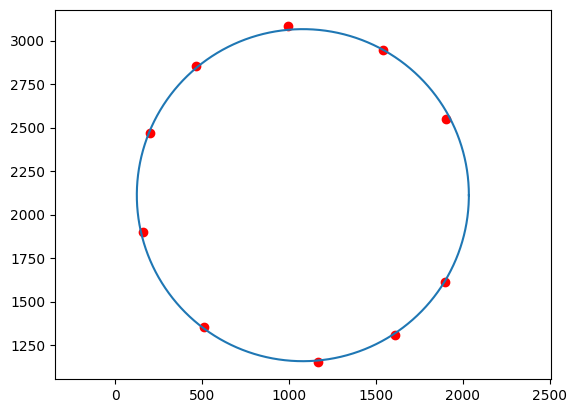

In [22]:
# Plot the fitted circle with the arena points
t = np.linspace(0, 2 * np.pi, 1000, endpoint=True)
plt.scatter(x = list(zip(*marker_averages))[0], y = list(zip(*marker_averages))[1], color='Red')
plt.plot(Ra * np.cos(t) + Ca[0], Ra * np.sin(t) + Ca[1])
plt.axis('equal')
plt.show()

## 4. Shifting and rescaling position coordinates of locusts

In [23]:
# Now that we have the position of the center of the arena, as well as the radius of the arena, 
# we can shift and normalise our coordinates so that the position of each locust is within [-1,1]x[-1,1]

#ldf[[f'X.{label}' for label in locust_labels]] = ((ldf[[f'X.{label}' for label in locust_labels]] - Ca[0])/Ra)
#ldf[[f'Y.{label}' for label in locust_labels]] = ((ldf[[f'Y.{label}' for label in locust_labels]] - Ca[1])/Ra)

In [24]:
ldf

,Frame,X.3,Y.3,Z.3,X.4,Y.4,Z.4,X.8,Y.8,Z.8,...,Z.1146,X.1154,Y.1154,Z.1154,X.1158,Y.1158,Z.1158,X.1160,Y.1160,Z.1160
Time,,,,,,,,,,,,,,,,,,,,,
0.00,1,-0.159048,-0.305136,31.858,0.045540,-0.699531,31.725,-0.267129,0.130171,33.730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.01,2,-0.159026,-0.305144,31.861,0.045579,-0.699546,31.734,-0.267109,0.130191,33.722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.02,3,-0.159005,-0.305140,31.860,0.045623,-0.699548,31.744,-0.267083,0.130226,33.724,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.03,4,-0.158980,-0.305145,31.846,0.045654,-0.699548,31.749,-0.267069,0.130230,33.721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.04,5,-0.159033,-0.304968,31.059,0.045730,-0.699727,31.257,-0.267017,0.130354,32.846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969.67,96968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.724,0.162216,0.187054,38.986,0.683668,0.461262,40.380,0.619832,0.171438,37.015
969.68,96969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.736,0.162346,0.187016,39.106,0.683515,0.462417,40.146,0.620090,0.171997,37.125
969.69,96970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.728,0.162460,0.187028,39.230,0.683465,0.463682,39.921,0.620283,0.172516,37.365
